# IMAGE CLASSIFICATION IN SPARK

## GROUP -1 
## Super Class : Household Electronics, Household Furniture

## Loading

In [52]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("CIFAR") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [736 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http://s

In [0]:
from pyspark import SparkContext
sc = spark.sparkContext

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql import Row

from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [55]:
#Getting Data
!wget "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

--2019-11-22 01:25:36--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.2’

cifar-100-python.ta 100%[===================>] 161.17M  13.7MB/s    in 13s     

2019-11-22 01:25:51 (12.2 MB/s) - ‘cifar-100-python.tar.gz.2’ saved [169001437/169001437]



In [56]:
#importing the file   https://stackoverflow.com/questions/47907306/python-os-path-dir-example   
import os
import sys
import tarfile

def data_extraction(filename, force=False):
   file_name = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
   print('Extracting data from %s.' % file_name)
   tar = tarfile.open(filename)
   sys.stdout.flush()
   tar.extractall('.')
   tar.close()

data_path = os.path.join('.', 'cifar-100-python.tar.gz')

data_extraction(data_path)

Extracting data from ./cifar-100-python.


In [0]:
#unpickle the file
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic
# Getting train data
train = unpickle('./cifar-100-python/train')
#Getting test data
test = unpickle('./cifar-100-python/test')
#Getting meta data
meta = unpickle("./cifar-100-python/meta")

In [58]:
#convert the data type from byte to utf-8
fine_labels = [x.decode('utf-8')for x in meta.get(b'fine_label_names')]
print(fine_labels)
coarse_labels = [x.decode('utf-8')for x in meta.get(b'coarse_label_names')]
print(coarse_labels)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [0]:
# Extracting the indexes of Superclasses(household_electrical_devices and household_furniture) 
electronics_index = [coarse_labels.index(x) for x in coarse_labels if x == 'household_electrical_devices']
furniture_index = [coarse_labels.index(x) for x in coarse_labels if x == 'household_furniture']

In [61]:
for i in coarse_labels:
  print(coarse_labels.index(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Combining Train and Test

In [9]:
for i in train:
  print(len(train[i]))

50000
21
50000
50000
50000


In [10]:
for i in test:
  print(len(test[i]))

10000
20
10000
10000
10000


In [11]:
train.pop(b'filenames')
test.pop(b'filenames')
train.pop(b'batch_label')
test.pop(b'batch_label')

b'testing batch 1 of 1'

In [0]:
for key, value in train.items():
  if key == b'data':
    train[key]=np.concatenate([value,test[key]],axis = 0)
  else:
    value.extend(test[key])

In [13]:
for i in train:
  print(len(train[i]))

60000
60000
60000


In [0]:
combined_data = train
del(train)

In [0]:
# combined_data

## Creating spark Dataframes

In [0]:
# generate the train data RDD ##if we dont give zip then it results in error as list can take utmost of 1 value
cifar_combined_rdd = sc.parallelize(list(zip( combined_data[b'fine_labels'], combined_data[b'coarse_labels'],combined_data[b'data'])))
# cifar_combined_rdd.count()

In [17]:
cifar_combined_rdd.take(2)

[(19, 11, array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)),
 (29, 15, array([255, 253, 253, ..., 253, 253, 255], dtype=uint8))]

In [0]:
import numpy as np
from pyspark.sql.types import Row
from pyspark.ml.linalg import Vectors
# Vectors.dense is used to convert int to float value.
# convert the RDD into spark dataframe
combined_df = spark.createDataFrame( cifar_combined_rdd.map(lambda x: Row(fine_labels=int(x[0]), coarse_labels=int(x[1]), data=Vectors.dense(x[2]/255.0))) )
# combined_df.count()

In [19]:
combined_df.show(5)

+-------------+--------------------+-----------+
|coarse_labels|                data|fine_labels|
+-------------+--------------------+-----------+
|           11|[1.0,1.0,1.0,1.0,...|         19|
|           15|[1.0,0.9921568627...|         29|
|            4|[0.98039215686274...|          0|
|           14|[0.48627450980392...|         11|
|            1|[0.16862745098039...|          1|
+-------------+--------------------+-----------+
only showing top 5 rows



## Filtering Electronics and Furniture superclasses

In [0]:
#get the index of ten classes
electronics = [fine_labels.index(x) for x in ['clock', 'keyboard', 'lamp', 'telephone', 'television']]
furniture =  [fine_labels.index(x) for x in ['bed', 'chair', 'couch', 'table', 'wardrobe']]
target_index=electronics+furniture
# print(electronics)
# print(furniture)
# print(target_index)

In [0]:
from pyspark.sql.functions import col
#filter out the assigned ten fine classes
target_df = combined_df.filter(col('fine_labels').isin(target_index))
# target_df.count()

## Visualizing Data

In [0]:
# electronics = [fine_labels.index(x) for x in ['clock', 'keyboard', 'lamp', 'telephone', 'television']]
# furniture =  [fine_labels.index(x) for x in ['bed', 'chair', 'couch', 'table', 'wardrobe']]
furniture_names = ['bed', 'chair', 'couch', 'table', 'wardrobe']
electronic_names = ['clock', 'keyboard', 'lamp', 'telephone', 'television']
dict_finelabels = {}
for i in range(len(electronics)):
  dict_finelabels[electronics[i]] = ('household_electrical_devices',electronic_names[i])
  dict_finelabels[furniture[i]] = ('household_furniture',furniture_names[i])

In [0]:
# target_df.select('fine_labels').show(1)

In [24]:
target_df.describe

<bound method DataFrame.describe of DataFrame[coarse_labels: bigint, data: vector, fine_labels: bigint]>

In [0]:
fractions = dict()
for fine_labels in [22, 39, 40, 86, 87, 5, 20, 25, 84, 94]:
  fractions[fine_labels] = 0.02

sample_df = target_df.sampleBy('fine_labels', fractions)
# sample_df.count()

In [0]:
# generate the samples list
samples = sample_df.select('coarse_labels', 'fine_labels', 'data').orderBy('coarse_labels', 'fine_labels').rdd.collect()

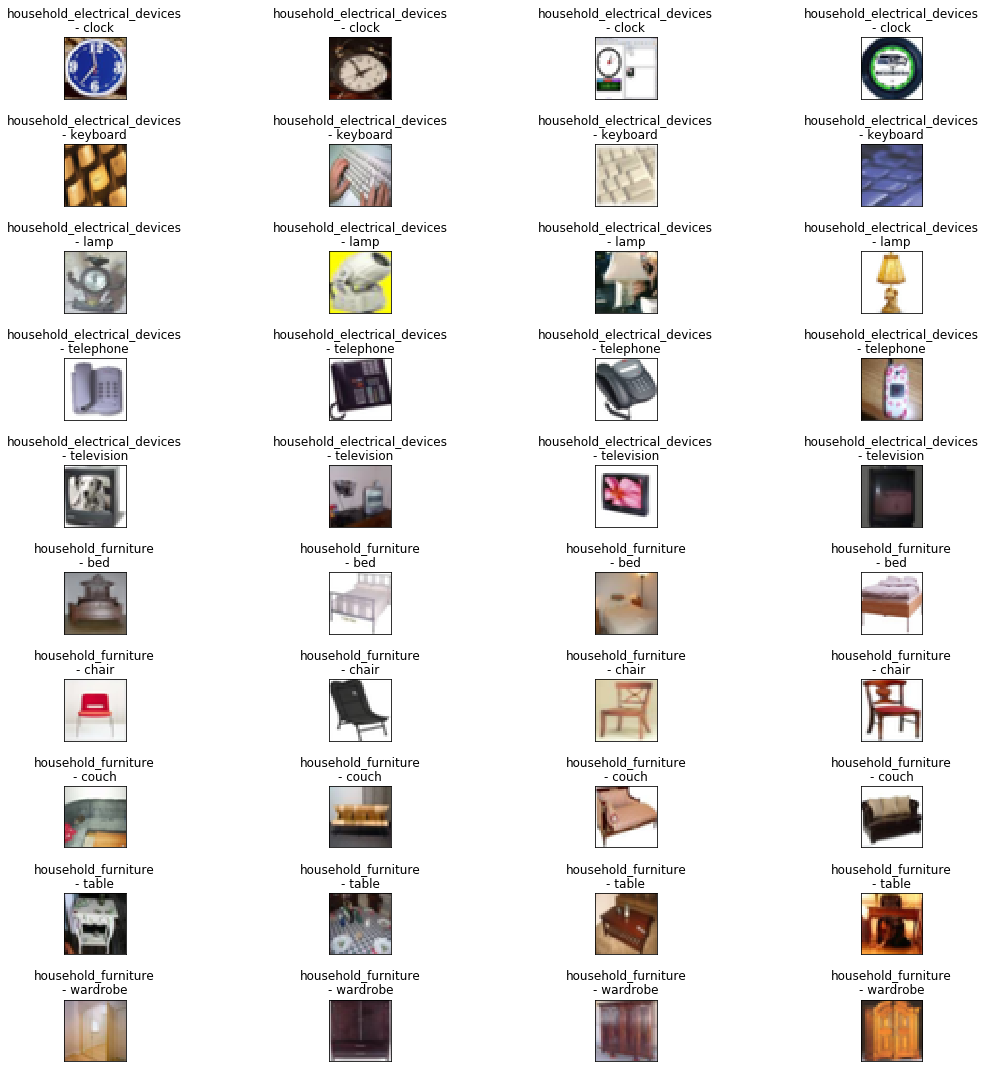

In [27]:
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0 
counts = dict.fromkeys((22, 39, 40, 86, 87, 5, 20, 25, 84, 94), 0) 

fig = plt.figure(figsize=(15, 15))

index = 0
for sample in samples:
  counts[sample.fine_labels] += 1
  if counts[sample.fine_labels] > 4:
    continue;
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])
  fig.add_subplot(10, 4, index+1, xticks=[], yticks=[])
  plt.imshow(img)

  plt.title("{}\n- {}".format(dict_finelabels[sample.fine_labels][0],dict_finelabels[sample.fine_labels][1]))
  index += 1
      
fig.set_tight_layout(True)

## Basic Formatting before model fitting

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [0]:
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='target')
stages = [stringindexer]
pipeline = Pipeline(stages=stages)

In [30]:
target_df_str = pipeline.fit(target_df).transform(target_df)
target_df_str.show(5)

+-------------+--------------------+-----------+------+
|coarse_labels|                data|fine_labels|target|
+-------------+--------------------+-----------+------+
|            5|[0.74509803921568...|         86|   1.0|
|            5|[0.32549019607843...|         39|   1.0|
|            5|[0.17254901960784...|         39|   1.0|
|            5|[1.0,0.9882352941...|         87|   1.0|
|            6|[0.17254901960784...|         84|   0.0|
+-------------+--------------------+-----------+------+
only showing top 5 rows



In [0]:
train, test = target_df_str.randomSplit([0.8, 0.2], seed=10)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="target")


In [0]:
from time import time

In [34]:
test.count()

1147

## Model 1- Naive Bayes

In [0]:
from pyspark.ml.classification import NaiveBayes
naivebayes = NaiveBayes(featuresCol="data", labelCol="target")

In [36]:
start = time()
model = naivebayes.fit(train)
print(" The time taken to build the Naive Bayes model is {:0.2f} minutes".format((time() - start)/60))

 The time taken to build the Naive Bayes model is 3.46 minutes


In [37]:
pred_train = model.transform(train)
pred_train.show(5)

+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|target|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|            5|[0.0,0.0,0.0,0.0,...|         86|   1.0|[-7930.5300938300...|[0.95123308566834...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         40|   1.0|[-2249.4031520263...|[0.99999999981776...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         22|   1.0|[-1929.1506645722...|[0.47506519533960...|       1.0|
|            5|[0.0,0.0,0.0,0.0,...|         22|   1.0|[-3456.0081531401...|[0.87364944318085...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         40|   1.0|[-4424.4681238297...|[0.98425914152000...|       0.0|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
only showing top 5 

In [38]:
pred_test = model.transform(test)
pred_test.show(5)

+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|target|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|            5|[0.0,0.0,0.0,0.0,...|         86|   1.0|[-10249.099669041...|[4.92511611064989...|       1.0|
|            5|[0.0,0.0,0.0,0.05...|         86|   1.0|[-6100.2561727931...|[0.77885244893638...|       0.0|
|            5|[0.00392156862745...|         87|   1.0|[-2377.7112660903...|[0.47005302817172...|       1.0|
|            5|[0.00392156862745...|         40|   1.0|[-10848.333378374...|[0.05175354924359...|       1.0|
|            5|[0.00392156862745...|         39|   1.0|[-10441.483103036...|[0.51980501409493...|       0.0|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
only showing top 5 

In [39]:
print('Test accuracy of {:0.2f} % '.format(evaluator.evaluate(pred_test)*100))

Test accuracy of 53.05 % 


### Confusion Matrix

In [40]:
train_conf_mat = pred_train.select('target', 'prediction')
train_conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(target=0.0, prediction=0.0): 1585,
             Row(target=0.0, prediction=1.0): 836,
             Row(target=1.0, prediction=0.0): 729,
             Row(target=1.0, prediction=1.0): 1703})

In [41]:
test_conf_mat = pred_test.select('target', 'prediction')
test_conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(target=0.0, prediction=0.0): 392,
             Row(target=0.0, prediction=1.0): 187,
             Row(target=1.0, prediction=0.0): 169,
             Row(target=1.0, prediction=1.0): 399})

In [74]:
# Compute raw scores on the test set
from pyspark.mllib.evaluation import BinaryClassificationMetrics
predictionAndLabels = pred_test.rdd.map(lambda lp: (lp.prediction, lp.target))
# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:35133)
Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

## Naive Bayes with cross Validation

In [0]:
from pyspark.ml.classification import NaiveBayes
naivebayes = NaiveBayes(featuresCol="data", labelCol="target")

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator1 = BinaryClassificationEvaluator(labelCol="target")

In [0]:
from pyspark.ml.tuning import ParamGridBuilder # similar to gridsearchCV
param_grid = ParamGridBuilder().\
    addGrid(naivebayes.smoothing, [0, 1, 2, 3]).\
    build()

In [0]:
# cross validation 
from pyspark.ml.tuning import CrossValidator
crossvalidator = CrossValidator(estimator=naivebayes, estimatorParamMaps=param_grid, evaluator=evaluator1, )

In [51]:
start4 = time()
crossvalidation_mode = crossvalidator.fit(train)
print(" The time taken to build the Naive Bayes model is {:0.2f} minutes".format((time() - start4)/60))

IllegalArgumentException: ignored

In [45]:
pred_cv_nb = crossvalidation_mode.transform(test)
pred_cv_nb.show(5)

+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|target|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|            5|[0.0,0.0,0.0,0.0,...|         86|   1.0|[-10249.099669041...|[4.92511611064989...|       1.0|
|            5|[0.0,0.0,0.0,0.05...|         86|   1.0|[-6100.2561727931...|[0.77885244893638...|       0.0|
|            5|[0.00392156862745...|         87|   1.0|[-2377.7112660903...|[0.47005302817172...|       1.0|
|            5|[0.00392156862745...|         40|   1.0|[-10848.333378374...|[0.05175354924359...|       1.0|
|            5|[0.00392156862745...|         39|   1.0|[-10441.483103036...|[0.51980501409493...|       0.0|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
only showing top 5 

In [46]:
print("The parameter smoothing has best value:",
      crossvalidation_mode.bestModel._java_obj.getSmoothing())

The parameter smoothing has best value: 1.0


In [48]:
print('Test accuracy of {:0.2f} % '.format(evaluator1.evaluate(pred_cv_nb)*100))

IllegalArgumentException: ignored

## Model 2 - Logistic Regression 

In [69]:
# first we check how LogisticRegression perform 
start2 = time()
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'data', labelCol = 'target', maxIter=15)
LR_model = LR.fit(train)
print(" The time taken to build the Logistic model is {:0.2f} minutes".format((time() - start2)/60))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:35133)
Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

In [0]:
pred_test_LR = LR_model.transform(test)
pred_test_LR.show(5)

+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|target|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
|            5|[0.0,0.0,0.0,0.0,...|         86|   1.0|[0.12314753881571...|[0.53074803588125...|       0.0|
|            5|[0.0,0.0,0.0,0.05...|         86|   1.0|[-0.0322978393279...|[0.49192624200113...|       1.0|
|            5|[0.00392156862745...|         87|   1.0|[0.20127577719861...|[0.55014975319455...|       0.0|
|            5|[0.00392156862745...|         40|   1.0|[-0.2001072444283...|[0.45013945805606...|       1.0|
|            5|[0.00392156862745...|         39|   1.0|[-0.7381805318017...|[0.32340213942084...|       1.0|
+-------------+--------------------+-----------+------+--------------------+--------------------+----------+
only showing top 5 

In [0]:
print('Test accuracy of {:0.2f} % '.format(evaluator.evaluate(pred_test_LR)*100))

Test accuracy of 73.05 % 


In [0]:
# Confusion matrix
test_conf_mat_LR = pred_test_LR.select('target', 'prediction')
test_conf_mat_LR.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(target=0.0, prediction=0.0): 407,
             Row(target=0.0, prediction=1.0): 172,
             Row(target=1.0, prediction=0.0): 215,
             Row(target=1.0, prediction=1.0): 353})

## Model 3 - Gradient Boosting Tree

In [68]:
# next we checkout gradient boosting trees
from pyspark.ml.classification import GBTClassifier
start3 = time()
gbt = GBTClassifier(featuresCol = 'data', labelCol = 'target',maxIter=15)
GBT_Model = gbt.fit(train)
print(" The time taken to build the GBT model is {:0.2f} minutes".format((time() - start3)/60))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:35133)
Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

In [0]:
gbt_predictions = GBT_Model.transform(test)
gbt_predictions.show(5)

In [0]:
print('Test accuracy of {:0.2f} % '.format(evaluator.evaluate(gbt_predictions)*100))

In [0]:
# Confusion matrix
test_conf_mat_GBT = gbt_predictions.select('target', 'prediction')
test_conf_mat_GBT.rdd.zipWithIndex().countByKey()

In [0]:
# metrics.

## Validation Images

In [0]:
fractions = dict()
for fine_labels in [22, 39, 40, 86, 87, 5, 20, 25, 84, 94]:
  fractions[fine_labels] = 0.02

sample_df_validate = pred_test.sampleBy('fine_labels', fractions)
sample_df_validate.count()

In [0]:
# generate the samples list
testData_validate = sample_df_validate.select('coarse_labels', 'fine_labels', 'data','prediction','target').orderBy('coarse_labels', 'fine_labels').rdd.collect()

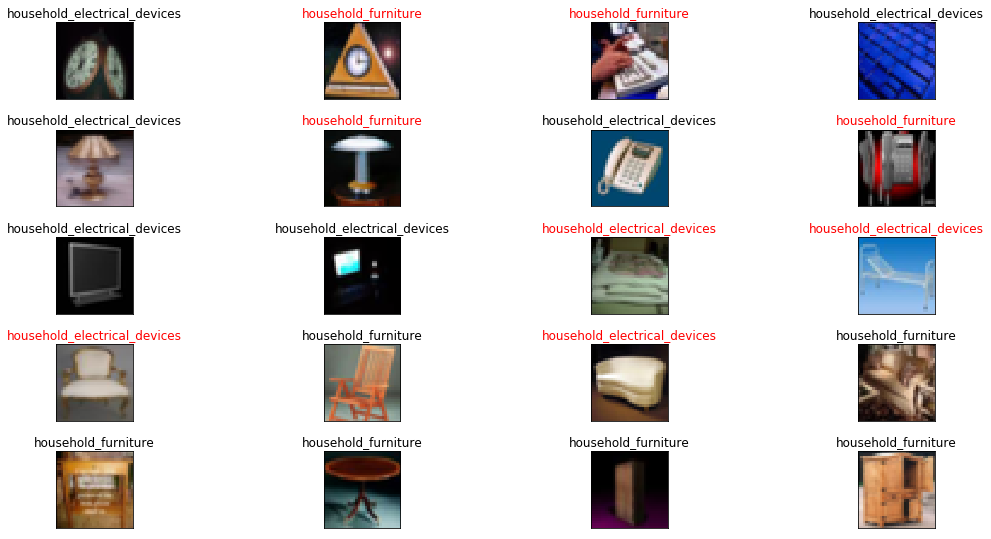

In [66]:
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0 
counts = dict.fromkeys((22, 39, 40, 86, 87, 5, 20, 25, 84, 94), 0)

fig = plt.figure(figsize=(15, 15))

index = 0
for sample in testData_validate:
  counts[sample.fine_labels] += 1
  if counts[sample.fine_labels] > 2:
    continue;
  
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])

  p_text = "household_electrical_devices" if sample.prediction == 1.0 else "household_furniture" 
  
  fig.add_subplot(10, 4, index+1, xticks=[], yticks=[])
  plt.imshow(img)
  #plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  if sample.prediction == sample.target:
    plt.title("{}".format(p_text))
  else:
    plt.title("{}".format(p_text),color="red")
  index += 1
      
fig.set_tight_layout(True)